In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import sys
sys.path.append('C:/Users/acomi/DESU_OFF/scripts')


In [30]:
path= "C:/Users/acomi/Downloads/data_DESU_2.csv"
df = pd.read_csv(path, delimiter=';', decimal = ",", encoding="utf-8", na_values=["", " "], na_filter=True)
df.head()

,mouse,vol(fv),perfctx,perfthal,Asp,bGlu,GABA,Gly,Gsh,Lac,Myo,tCo,tNa,Glx,tCr,behav
0,C1-2R,0.058380,44.14,69.0910,8.982798e-02,0.101835,0.080081,0.123462,0.012413,0.071801,2.445724e-01,0.079899,0.095911,0.360444,0.414571,106.50
1,C1-4V,0.054904,119.74,173.4525,2.070000e-17,0.149997,0.199037,0.072974,0.133746,0.083009,1.058961e-01,0.073409,0.103809,0.251717,0.245582,116.24
2,C3-1N,0.054323,117.88,110.9430,2.050000e-17,0.030867,0.108392,0.174835,0.057111,0.057157,1.831715e-01,0.043085,0.098994,0.300538,0.301312,112.30
3,C3-3N,0.057803,49.63,65.0625,5.419405e-02,0.262064,0.072793,0.150699,0.123286,0.133484,3.325312e-01,0.112738,0.401151,0.443224,0.741725,5.92
4,C3-4N,0.052949,NaN,NaN,1.113894e-01,0.145943,0.006817,0.161985,0.157758,0.117177,2.660000e-17,0.080647,0.248493,0.514835,0.572566,8.60


In [31]:
df = df.drop(['mouse'], axis = 1)

In [32]:
#check the data for missing values
percent_missing=df.isnull().sum()*100/len(df)
print(percent_missing)
percent_missing.sort_values(ascending=False,inplace=True)

vol(fv)      0.000000
perfctx      9.433962
perfthal     9.433962
Asp         22.641509
bGlu        22.641509
GABA        22.641509
Gly         22.641509
Gsh         22.641509
Lac         22.641509
Myo         22.641509
tCo         22.641509
tNa         22.641509
Glx         22.641509
tCr         22.641509
behav        0.000000
dtype: float64


## Exploring the dataset

### Distribution of the data (normality)

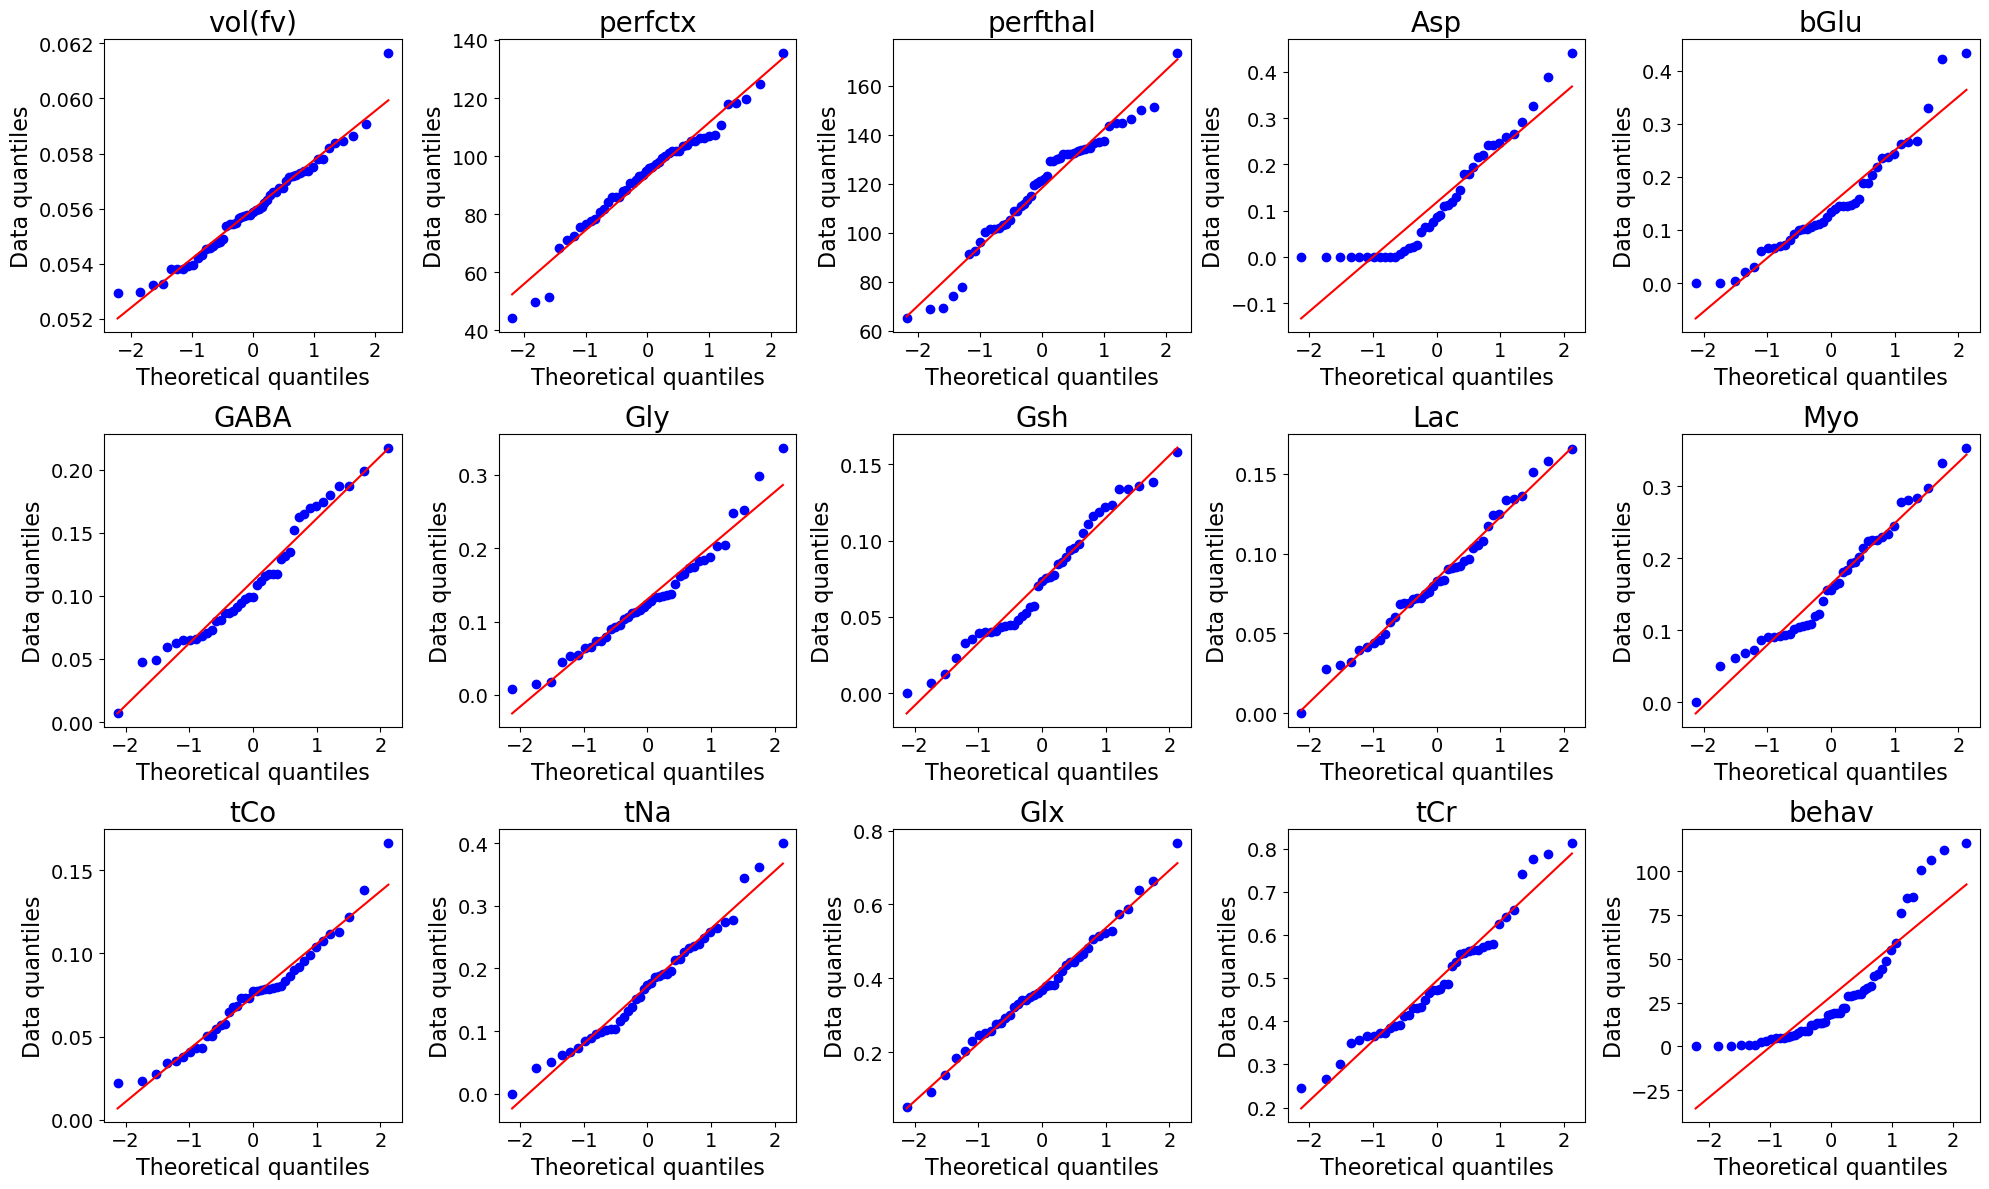

In [50]:
#Q-Q plots for all variables to check the distribution of the data
num_cols = df.select_dtypes(include=["number"]).columns
n_rows, n_cols = 3, 5 #grid size

fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 4*n_rows))
axes = axes.flatten()  
for i, col in enumerate(num_cols):
    data = df[col].dropna()  # ignore NaNs
    stats.probplot(data, dist="norm", plot=axes[i])
    axes[i].set_title(col, fontsize = 20)
    axes[i].set_xlabel('Theoretical quantiles', fontsize=16)
    axes[i].set_ylabel('Data quantiles', fontsize=16)
for ax in axes:
    ax.tick_params(axis="both", labelsize=14)

plt.tight_layout()
plt.show()

### Visualization of the data and outliers

    Variable  Num_Outliers
0      behav             6
1    perfctx             4
2       bGlu             2
3        Gly             1
4        Glx             1
5        tCo             1
6    vol(fv)             1
7       GABA             0
8        Asp             0
9   perfthal             0
10       Gsh             0
11       Myo             0
12       Lac             0
13       tNa             0
14       tCr             0


C:\Users\acomi\AppData\Local\Temp\ipykernel_18988\1423944468.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x="Variable", y="Value", data=df_long, palette="Set2")


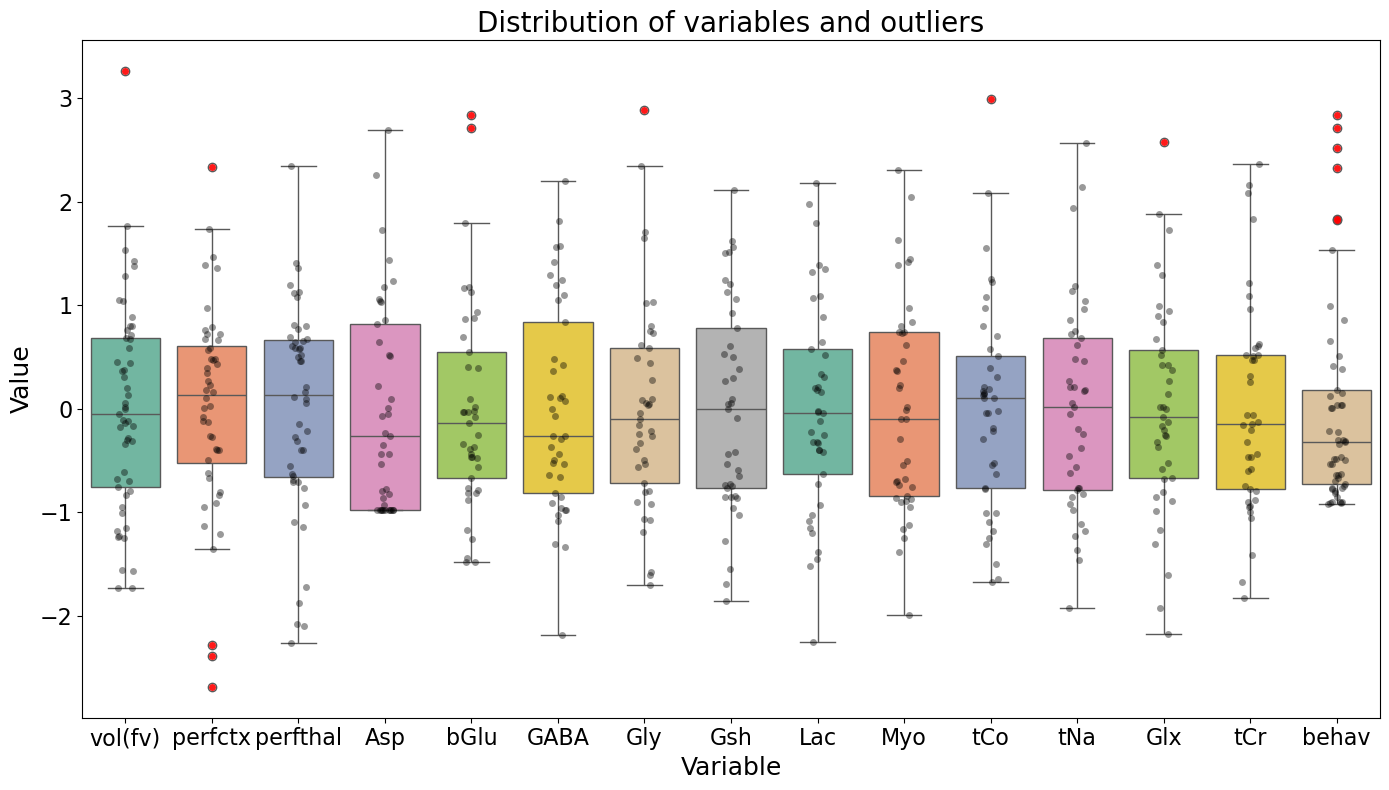

In [55]:
from sklearn.preprocessing import StandardScaler

# Scaling of variables for visualization purposes
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df[num_cols]), columns=num_cols, index=df.index)

# Detection of outliers using IQR

outliers = pd.DataFrame(False, index=df_scaled.index, columns=df_scaled.columns)

for col in df_scaled.columns:
    Q1 = df_scaled[col].quantile(0.25)
    Q3 = df_scaled[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers[col] = (df_scaled[col] < lower_bound) | (df_scaled[col] > upper_bound)

outlier_counts = outliers.sum().sort_values(ascending=False)
outlier_table = pd.DataFrame({"Variable": outlier_counts.index,"Num_Outliers": outlier_counts.values})
print(outlier_table)

# Reshape for plotting and boxplot with all points
df_long = df_scaled.melt(var_name="Variable", value_name="Value")
df_long["Outlier"] = outliers.melt(var_name="Variable", value_name="Outlier")["Outlier"]

plt.figure(figsize=(14, 8))
ax = sns.boxplot(x="Variable", y="Value", data=df_long, palette="Set2")
sns.stripplot(x="Variable", y="Value", data=df_long[~df_long["Outlier"]],color="black", size=5, jitter=True, alpha=0.4) #all data points that are not outliers
sns.stripplot(x="Variable", y="Value", data=df_long[df_long["Outlier"]],color="red", size=5, jitter=False, alpha=0.9, marker="o") #outliers

ax.set_xlabel("Variable", fontsize=18)
ax.set_ylabel("Value", fontsize=18)
ax.set_title("Distribution of variables and outliers", fontsize=20)
ax.tick_params(axis="both", labelsize=16)

plt.tight_layout()
plt.show()

In [56]:
#We remove outliers in the selected columns

cols_to_clean = ["vol(fv)", "perfctx", "bGlu", "Gly", "tCo", "Glx"]

work_df = df.copy()

for col in cols_to_clean:
    Q1 = work_df[col].quantile(0.25)
    Q3 = work_df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Replace outliers with NaN 
    work_df.loc[(work_df[col] < lower_bound) | (work_df[col] > upper_bound), col] = np.nan


### Correlation matrix

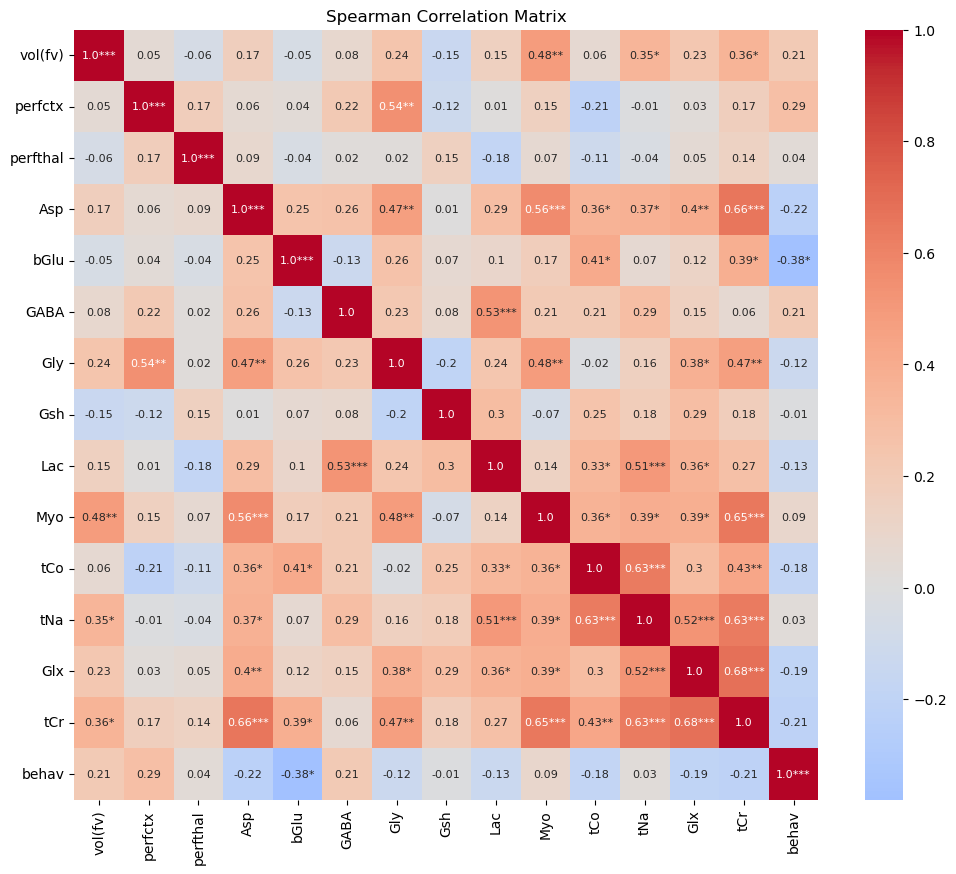

Top correlations with behavior:
          Correlation  p-value
Variable                      
perfctx         0.287    0.059
GABA            0.211    0.185
vol(fv)         0.206    0.143
bGlu           -0.380    0.017
Asp            -0.224    0.159
tCr            -0.211    0.185


In [57]:
from scipy.stats import spearmanr
cols = work_df.columns
corr_matrix = pd.DataFrame(np.zeros((len(cols), len(cols))), columns=cols, index=cols)
pval_matrix = pd.DataFrame(np.zeros((len(cols), len(cols))), columns=cols, index=cols)

for i in range(len(cols)):
    for j in range(len(cols)):
        if i <= j:  # we avoid duplicate calculations
            corr, pval = spearmanr(work_df[cols[i]], work_df[cols[j]], nan_policy="omit")
            corr_matrix.iloc[i, j] = corr_matrix.iloc[j, i] = corr
            pval_matrix.iloc[i, j] = pval_matrix.iloc[j, i] = pval

def significance_stars(p):
    if p < 0.001:
        return "***"
    elif p < 0.01:
        return "**"
    elif p < 0.05:
        return "*"
    else:
        return ""

# Annotation matrix with corr + stars
annot_matrix = corr_matrix.round(2).astype(str)
for i in range(len(cols)):
    for j in range(len(cols)):
        star = significance_stars(pval_matrix.iloc[i, j])
        annot_matrix.iloc[i, j] = annot_matrix.iloc[i, j] + star

#Heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix.astype(float), annot=annot_matrix, fmt="", 
            annot_kws={"size": 8}, cmap="coolwarm", center=0)
plt.title("Spearman Correlation Matrix")
plt.show()

# Produce top correlations with behavior
results = []
for col in work_df.columns:
    if col != "behav":
        corr, pval = spearmanr(work_df["behav"], work_df[col], nan_policy="omit")
        results.append({"Variable": col, "Correlation": corr, "p-value": pval})

corr_df = pd.DataFrame(results).set_index("Variable")
top_positive = corr_df.sort_values("Correlation", ascending=False).head(3)
top_negative = corr_df.sort_values("Correlation").head(3)
top_corr_df = pd.concat([top_positive, top_negative])

print("Top correlations with behavior:")
print(top_corr_df.round(3))

Excluded variables due to multicolinearity ['tCr']


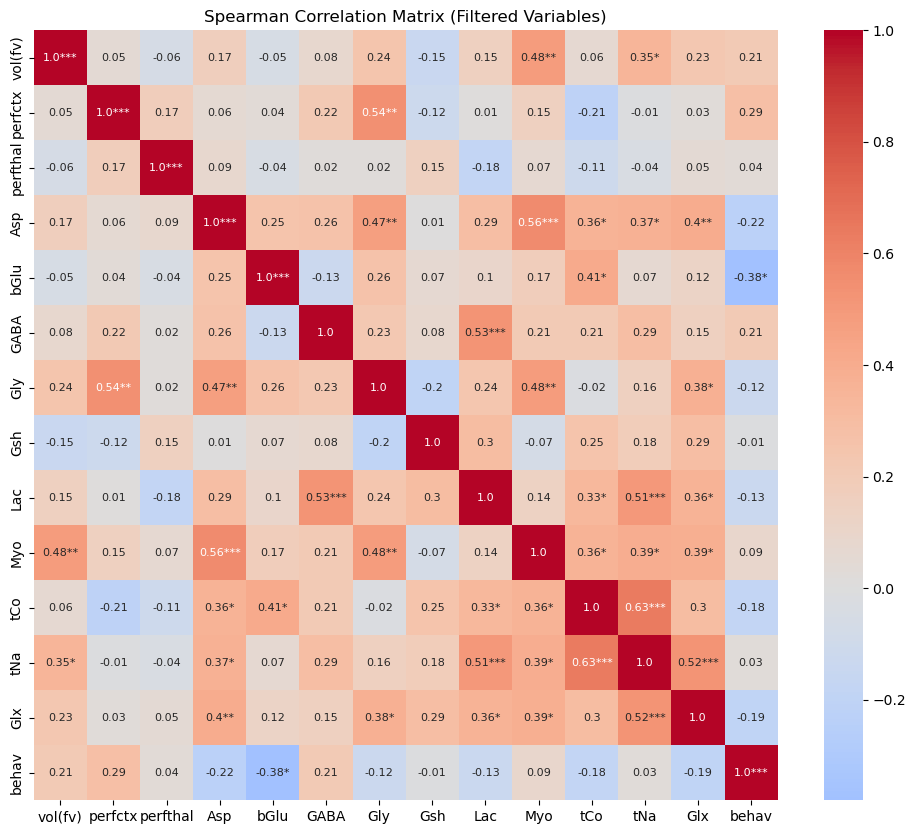

Top correlations with behavior (after filtering):
          Correlation  p-value
Variable                      
perfctx         0.287    0.059
GABA            0.211    0.185
vol(fv)         0.206    0.143
bGlu           -0.380    0.017
Asp            -0.224    0.159
Glx            -0.193    0.234


In [58]:
# Identify variables to exclude: correlation > 0.6 with more than 2 other variables
exclude_vars = []
threshold = 0.6
max_allowed = 2

for col in corr_matrix.columns:
    # Count how many correlations (excluding self) exceed threshold
    high_corr_count = (corr_matrix[col].abs() > threshold).sum() - 1  # subtract self-correlation
    if high_corr_count > max_allowed:
        exclude_vars.append(col)

print("Excluded variables due to multicolinearity", exclude_vars)

included_vars = [c for c in work_df.columns if c not in exclude_vars]


# New correlation matrix
cols = included_vars
new_corr_matrix = pd.DataFrame(np.zeros((len(cols), len(cols))), columns=cols, index=cols)
new_pval_matrix = pd.DataFrame(np.zeros((len(cols), len(cols))), columns=cols, index=cols)

for i in range(len(cols)):
    for j in range(len(cols)):
        if i <= j:
            corr, pval = spearmanr(work_df[cols[i]], work_df[cols[j]], nan_policy="omit")
            new_corr_matrix.iloc[i, j] = new_corr_matrix.iloc[j, i] = corr
            new_pval_matrix.iloc[i, j] = new_pval_matrix.iloc[j, i] = pval

def significance_stars(p):
    if p < 0.001:
        return "***"
    elif p < 0.01:
        return "**"
    elif p < 0.05:
        return "*"
    else:
        return ""

annot_matrix = new_corr_matrix.round(2).astype(str)
for i in range(len(cols)):
    for j in range(len(cols)):
        star = significance_stars(new_pval_matrix.iloc[i, j])
        annot_matrix.iloc[i, j] = annot_matrix.iloc[i, j] + star

plt.figure(figsize=(12, 10))
sns.heatmap(new_corr_matrix.astype(float), annot=annot_matrix, fmt="",
            annot_kws={"size": 8}, cmap="coolwarm", center=0)
plt.title("Spearman Correlation Matrix (Filtered Variables)")
plt.show()

results = []
for col in included_vars:
    if col != "behav":
        corr, pval = spearmanr(work_df["behav"], work_df[col], nan_policy="omit")
        results.append({"Variable": col, "Correlation": corr, "p-value": pval})

corr_df = pd.DataFrame(results).set_index("Variable")
top_positive = corr_df.sort_values("Correlation", ascending=False).head(3)
top_negative = corr_df.sort_values("Correlation").head(3)
top_corr_df = pd.concat([top_positive, top_negative])

print("Top correlations with behavior (after filtering):")
print(top_corr_df.round(3))

In [59]:
work_df = work_df.drop(columns=["tCr"])

### ML Pipeline

In [41]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.cross_decomposition import PLSRegression
from sklearn.impute import KNNImputer
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import LeaveOneOut, GridSearchCV, learning_curve
from sklearn.metrics import mean_squared_error, r2_score
from collections import Counter
from pls_fselector import PLSFeatureSelector 
from learning_curve import plot_learning_curve
from shap_regr import plot_shap_summary


X = work_df.drop(columns=["behav"]).values
y = work_df["behav"].values
feature_names = work_df.drop(columns=["behav"]).columns

loo = LeaveOneOut()


#### Lasso regression

Best alpha Lasso: 2.976351441631316
LOO-CV Lasso+PLS: MSE=926.365, R²=0.032

Feature selection stability aka each feature was chosen:
perfctx: 53/53 times
bGlu: 53/53 times
vol(fv): 52/53 times
Myo: 51/53 times
Asp: 34/53 times
Glx: 9/53 times
tNa: 6/53 times
GABA: 2/53 times
Gsh: 1/53 times
perfthal: 1/53 times
Gly: 1/53 times
Lac: 1/53 times
tCo: 1/53 times


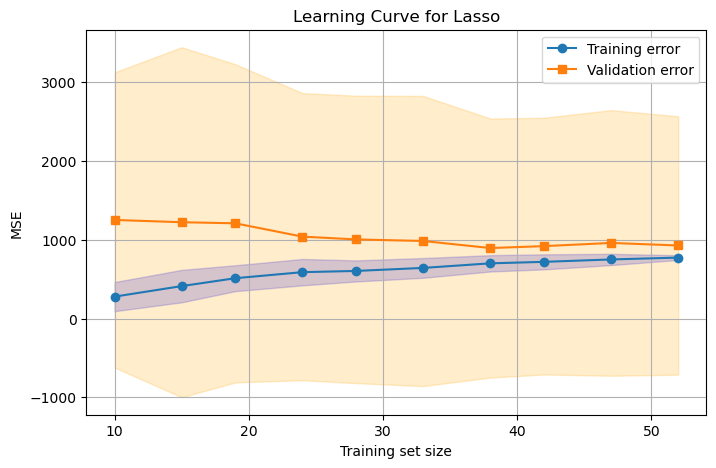


SHAP summary (regression or binary classification):


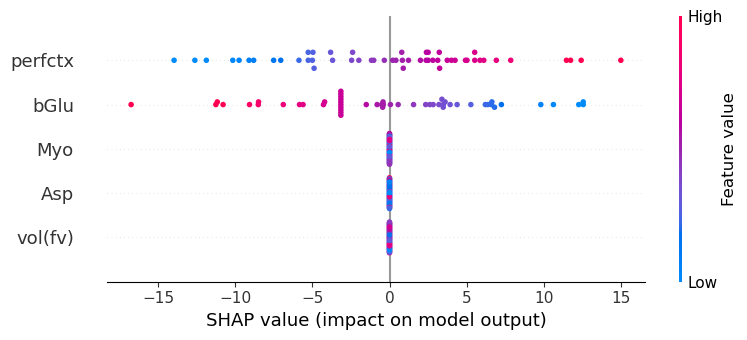

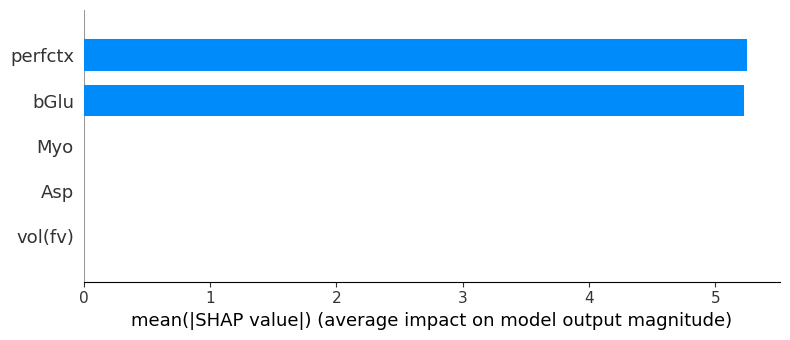

In [42]:
from sklearn.linear_model import Lasso

# Pipeline: Imputer + Scaler + PLS selection + Model

pipe = Pipeline([
    ("imputer", KNNImputer(n_neighbors=3)),
    ("scaler", RobustScaler()),
    ("pls_select", PLSFeatureSelector(n_components=2, n_features=5, feature_names=feature_names)),
    ("lasso", Lasso(max_iter=10000))
])

# Hyperparameter gridsearch
param_grid = {"lasso__alpha": np.logspace(-3, 3, 20)}
grid = GridSearchCV(pipe, param_grid, cv=loo, scoring="neg_mean_squared_error")
grid.fit(X, y)
best_alpha = grid.best_params_["lasso__alpha"]
print("Best alpha Lasso:", best_alpha)

# Evaluate with LOO-CV (and chosen hyperparameters) and track selected features

pipe_best = Pipeline([
    ("imputer", KNNImputer(n_neighbors=3)),
    ("scaler", RobustScaler()),
    ("pls_select", PLSFeatureSelector(n_components=2, n_features=5, feature_names=feature_names)),
    ("lasso", Lasso(alpha=best_alpha, max_iter=10000))
])

y_pred = np.zeros_like(y, dtype=float)
selected_features_all = []

for train_idx, test_idx in loo.split(X):
    pipe_best.fit(X[train_idx], y[train_idx])
    y_pred[test_idx] = pipe_best.predict(X[test_idx])
    selected_features_all.extend(pipe_best.named_steps["pls_select"].get_feature_names())

mse = mean_squared_error(y, y_pred)
r2 = r2_score(y, y_pred)
print(f"LOO-CV Lasso+PLS: MSE={mse:.3f}, R²={r2:.3f}")

#Feature stability to ensure the used ones are almost always the same
feature_counts = Counter(selected_features_all)
print("\nFeature selection stability aka each feature was chosen:")
for feat, count in feature_counts.most_common():
    print(f"{feat}: {count}/{len(y)} times")

#Plotting of the learning curve
plot_learning_curve(pipe_best, X, y, cv=loo, scoring="neg_mean_squared_error", title="Learning Curve for Lasso")

#Shap to visually explain the model
plot_shap_summary(pipe_best, X, y, feature_step="pls_select", model_step="lasso")

#### Ridge regression

Best alpha Ridge: 54.555947811685144
LOO-CV Ridge+PLS: MSE=967.704, R²=-0.011

Feature selection stability aka each feature was chosen:
perfctx: 53/53 times
bGlu: 53/53 times
vol(fv): 52/53 times
Myo: 51/53 times
Asp: 34/53 times
Glx: 9/53 times
tNa: 6/53 times
GABA: 2/53 times
Gsh: 1/53 times
perfthal: 1/53 times
Gly: 1/53 times
Lac: 1/53 times
tCo: 1/53 times


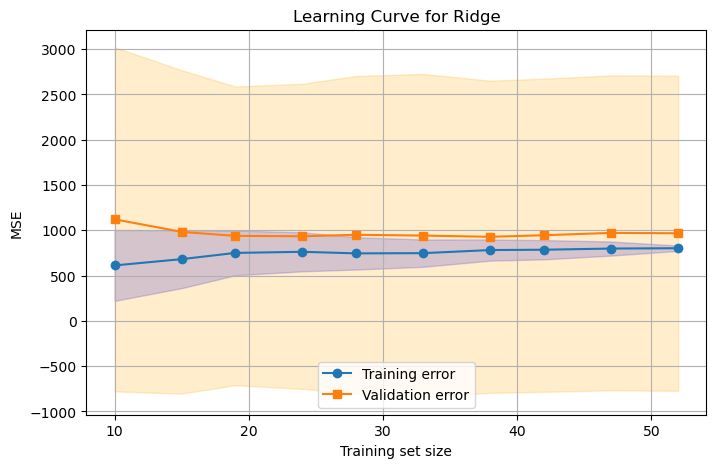


SHAP summary (regression or binary classification):


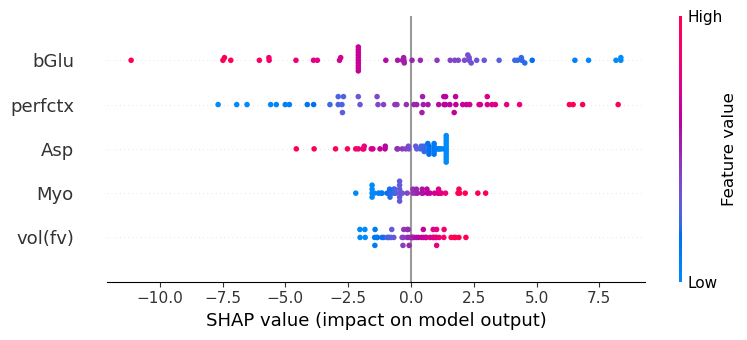

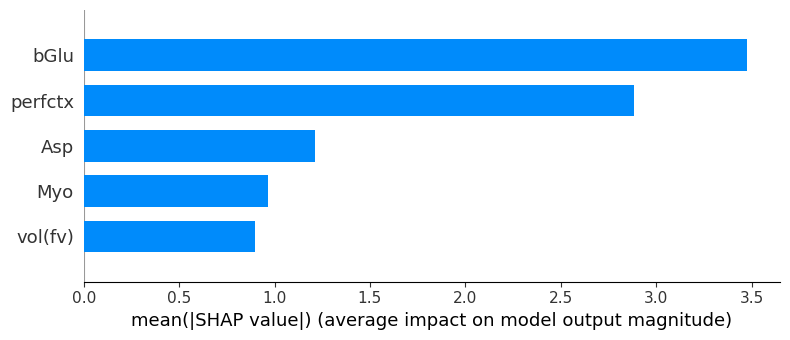

In [43]:
from sklearn.linear_model import Ridge

# Pipeline: Imputer + Scaler + PLS selection + Model

pipe = Pipeline([
    ("imputer", KNNImputer(n_neighbors=3)),
    ("scaler", RobustScaler()),
    ("pls_select", PLSFeatureSelector(n_components=2, n_features=5, feature_names=feature_names)),
    ("ridge", Ridge())
])

# Hyperparameter gridsearch
param_grid = {"ridge__alpha": np.logspace(-3, 3, 20)}
grid = GridSearchCV(pipe, param_grid, cv=loo, scoring="neg_mean_squared_error")
grid.fit(X, y)
best_alpha = grid.best_params_["ridge__alpha"]
print("Best alpha Ridge:", best_alpha)

# Evaluate with LOO-CV and track selected features

pipe_best = Pipeline([
    ("imputer", KNNImputer(n_neighbors=3)),
    ("scaler", RobustScaler()),
    ("pls_select", PLSFeatureSelector(n_components=2, n_features=5, feature_names=feature_names)),
    ("ridge", Ridge(alpha=best_alpha))
])

y_pred = np.zeros_like(y, dtype=float)
selected_features_all = []

for train_idx, test_idx in loo.split(X):
    pipe_best.fit(X[train_idx], y[train_idx])
    y_pred[test_idx] = pipe_best.predict(X[test_idx])
    selected_features_all.extend(pipe_best.named_steps["pls_select"].get_feature_names())

mse = mean_squared_error(y, y_pred)
r2 = r2_score(y, y_pred)
print(f"LOO-CV Ridge+PLS: MSE={mse:.3f}, R²={r2:.3f}")

#Feature stability to ensure the used ones are almost always the same
feature_counts = Counter(selected_features_all)
print("\nFeature selection stability aka each feature was chosen:")
for feat, count in feature_counts.most_common():
    print(f"{feat}: {count}/{len(y)} times")

#Plotting of the learning curve
plot_learning_curve(pipe_best, X, y, cv=loo, scoring="neg_mean_squared_error", title="Learning Curve for Ridge")

#Shap to visually explain the model
plot_shap_summary(pipe_best, X, y, feature_step="pls_select", model_step="ridge")

#### Elastic Net

Best alpha: 2.154434690031882
Best l1_ratio: 0.7
LOO-CV ElasticNet+PLS: MSE=957.254, R²=0.00014

Feature selection stability aka each feature was chosen:
perfctx: 53/53 times
bGlu: 53/53 times
vol(fv): 52/53 times
Myo: 51/53 times
Asp: 34/53 times
Glx: 9/53 times
tNa: 6/53 times
GABA: 2/53 times
Gsh: 1/53 times
perfthal: 1/53 times
Gly: 1/53 times
Lac: 1/53 times
tCo: 1/53 times


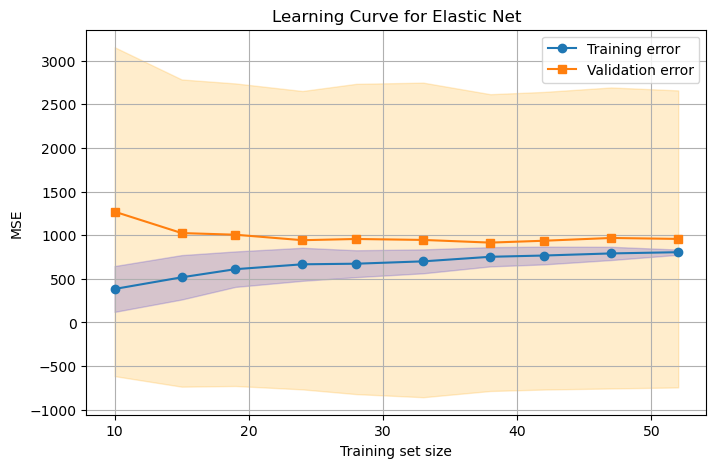


SHAP summary (regression or binary classification):


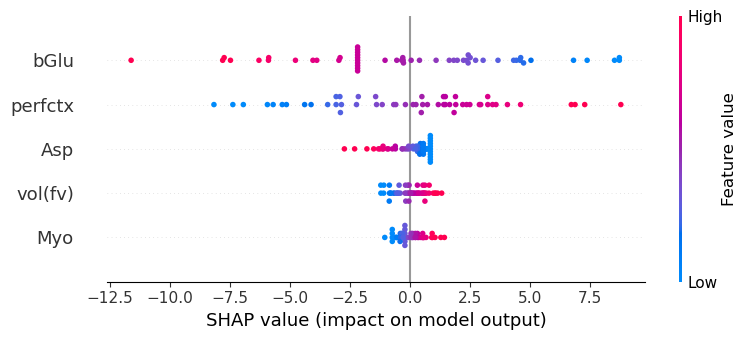

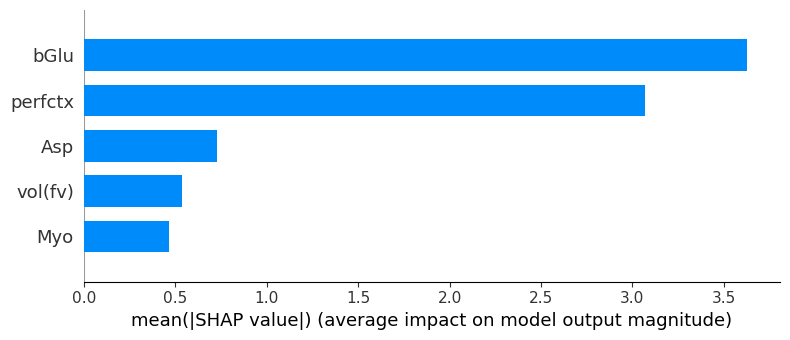

In [45]:
from sklearn.linear_model import ElasticNet

# Pipeline: Imputer + Scaler + PLS + Model

pipe = Pipeline([
    ("imputer", KNNImputer(n_neighbors=3)),
    ("scaler", RobustScaler()),
    ("pls_select", PLSFeatureSelector(n_components=2, n_features=5, feature_names=feature_names)),
    ("elasticnet", ElasticNet(max_iter=50000))
])

# Hyperparameter grid
param_grid = {
    "elasticnet__alpha": np.logspace(-3, 3, 10),
    "elasticnet__l1_ratio": [0.1, 0.5, 0.7, 0.9, 1.0]  # 1.0 = Lasso, 0.0 = Ridge
}


grid = GridSearchCV(pipe, param_grid, cv=loo, scoring="neg_mean_squared_error")
grid.fit(X, y)
best_alpha = grid.best_params_["elasticnet__alpha"]
best_l1_ratio = grid.best_params_["elasticnet__l1_ratio"]
print("Best alpha:", best_alpha)
print("Best l1_ratio:", best_l1_ratio)


# Evaluate with LOO-CV and track selected features

pipe_best = Pipeline([
    ("imputer", KNNImputer(n_neighbors=3)),
    ("scaler", RobustScaler()),
    ("pls_select", PLSFeatureSelector(n_components=2, n_features=5, feature_names=feature_names)),
    ("elasticnet", ElasticNet(alpha=best_alpha, l1_ratio=best_l1_ratio, max_iter=50000))
])

y_pred = np.zeros_like(y, dtype=float)
selected_features_all = []

for train_idx, test_idx in loo.split(X):
    pipe_best.fit(X[train_idx], y[train_idx])
    y_pred[test_idx] = pipe_best.predict(X[test_idx])
    selected_features_all.extend(pipe_best.named_steps["pls_select"].get_feature_names())

mse = mean_squared_error(y, y_pred)
r2 = r2_score(y, y_pred)
print(f"LOO-CV ElasticNet+PLS: MSE={mse:.3f}, R²={r2:.5f}")

# see selected features to asure consistency in the selection
feature_counts = Counter(selected_features_all)
print("\nFeature selection stability aka each feature was chosen:")
for feat, count in feature_counts.most_common():
    print(f"{feat}: {count}/{len(y)} times")


#Plotting of the learning curve
plot_learning_curve(pipe_best, X, y, cv=loo, scoring="neg_mean_squared_error", title="Learning Curve for Elastic Net")

#Shap to visually explain the model
plot_shap_summary(pipe_best, X, y, feature_step="pls_select", model_step="elasticnet")

#### Decision Tree

Best Decision Tree params: {'tree__max_depth': 2, 'tree__min_samples_leaf': 1, 'tree__min_samples_split': 2}
LOO-CV DecisionTree+PLS: MSE=822.075, R²=0.141

Feature selection stability aka each feature was chosen:
perfctx: 53/53 times
bGlu: 53/53 times
vol(fv): 52/53 times
Myo: 51/53 times
Asp: 34/53 times
Glx: 9/53 times
tNa: 6/53 times
GABA: 2/53 times
Gsh: 1/53 times
perfthal: 1/53 times
Gly: 1/53 times
Lac: 1/53 times
tCo: 1/53 times


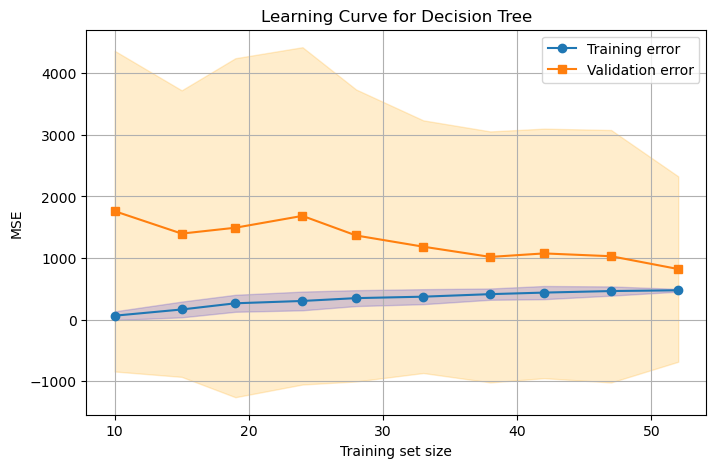


SHAP summary (regression or binary classification):


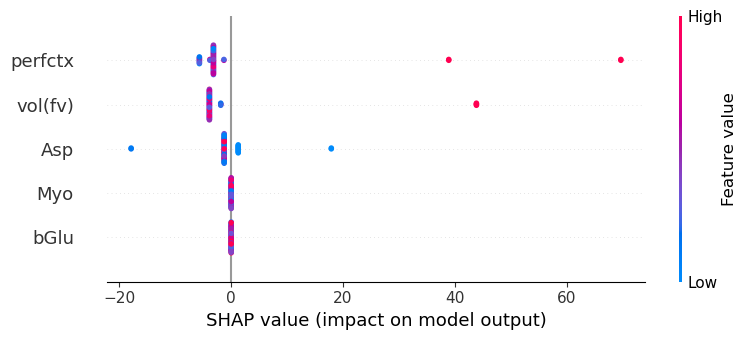

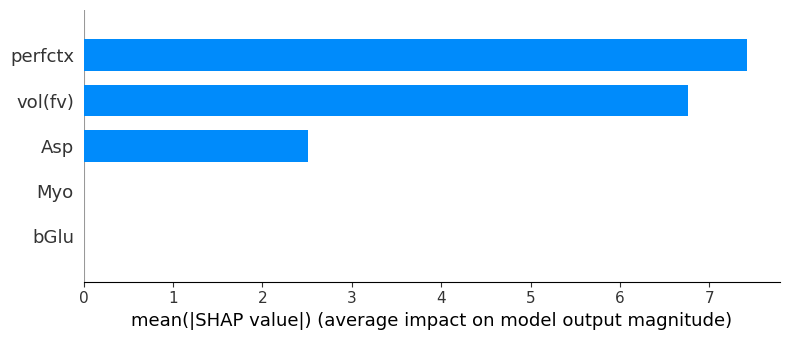

In [60]:
from sklearn.tree import DecisionTreeRegressor

#Pipeline = imputing + scaling + feature selection (PLS) + model
pipe = Pipeline([
    ("imputer", KNNImputer(n_neighbors=3)),
    ("scaler", RobustScaler()),
    ("pls_select", PLSFeatureSelector(n_components=2, n_features=5, feature_names=feature_names)),
    ("tree", DecisionTreeRegressor(random_state=42))
])

# Hyperparameter grid for decision tree
param_grid = {
    "tree__max_depth": [2, 3, 4, 5, None],
    "tree__min_samples_split": [2, 5, 10],
    "tree__min_samples_leaf": [1, 2, 4]
}

grid = GridSearchCV(pipe, param_grid, cv=loo, scoring="neg_mean_squared_error")
grid.fit(X, y)
best_params = grid.best_params_
best_params_clean = {k.replace("tree__", ""): v for k, v in best_params.items()}
print("Best Decision Tree params:", best_params)

# Evaluation with loo-cv
pipe_best = Pipeline([
    ("imputer", KNNImputer(n_neighbors=3)),
    ("scaler", RobustScaler()),
    ("pls_select", PLSFeatureSelector(n_components=2, n_features=5, feature_names=feature_names)),
    ("tree", DecisionTreeRegressor(**best_params_clean, random_state=42))
])

y_pred = np.zeros_like(y, dtype=float)
selected_features_all = []

for train_idx, test_idx in loo.split(X):
    pipe_best.fit(X[train_idx], y[train_idx])
    y_pred[test_idx] = pipe_best.predict(X[test_idx])
    selected_features_all.extend(pipe_best.named_steps["pls_select"].get_feature_names())

mse = mean_squared_error(y, y_pred)
r2 = r2_score(y, y_pred)
print(f"LOO-CV DecisionTree+PLS: MSE={mse:.3f}, R²={r2:.3f}")

#Reporting on chosen features
feature_counts = Counter(selected_features_all)
print("\nFeature selection stability aka each feature was chosen:")
for feat, count in feature_counts.most_common():
    print(f"{feat}: {count}/{len(y)} times")

#Plotting of the learning curve
plot_learning_curve(pipe_best, X, y, cv=loo, scoring="neg_mean_squared_error", title="Learning Curve for Decision Tree")

#Shap to visually explain the model
plot_shap_summary(pipe_best, X, y, feature_step="pls_select", model_step="tree")